In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from skimage import io, img_as_float
from sklearn.model_selection import train_test_split

In [2]:
train_data_path = '../sorted_train_data'
categories = ['cherry', 'strawberry', 'tomato']

# Step 2: Apply pre-processing techniques to improve quality of the data.

For simple pre-processing, you can just simply remove some noisy images/instances. Alternatively, you could apply feature engineering techniques (e.g. image feature descriptors to extract high-level features, feature extraction, or feature constructions) to try and improve the quality of the data and hence classification accuracy of your final model.

## Resizing and Aspect Ratio Normalization

Ensures that all images in the dataset are of the same size

In [3]:
def resize_images(image_paths, target_size=(300, 300)):
    resized_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, target_size)
        resized_images.append(img_resized)
    return resized_images

## Preprocess Images through Flattening

Ensures images are flattened to remove noise

In [4]:
def preprocess_images(images, target_size=(300, 300)):
    processed_images = []
    for img in images:
        if img.dtype != np.float32:
            img = img.astype(np.float32)
        if len(img.shape) == 2:
            img_resized = cv2.resize(img, target_size)
        elif len(img.shape) == 3:
            img_resized = cv2.resize(img, target_size)
        processed_images.append(img_resized)
    return np.array(processed_images)

## Blurring and Noise Reduction

Apply Gaussian blue to reduce noise in the image. useful when images contain high-frequency details.

In [5]:
def apply_blur(image, ksize=(5, 5)):
    return cv2.GaussianBlur(image, ksize, 0)

## Loader Method

Loads all images given their respect category

In [6]:
def load_images_from_category(category):
    category_path = os.path.join(train_data_path, category)
    image_files = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith('.jpg')]
    images = [img_as_float(io.imread(img)) for img in image_files]
    return images

## Perform Normalization on Images

Load images from their respective dataset category

In [7]:
cherry_images = load_images_from_category('cherry')
strawberry_images = load_images_from_category('strawberry')
tomato_images = load_images_from_category('tomato')

Convert image dtypes to float32

In [8]:
cherry_images = [img.astype(np.float32) for img in cherry_images]
strawberry_images = [img.astype(np.float32) for img in strawberry_images]
tomato_images = [img.astype(np.float32) for img in tomato_images]

Get total count of image categories to understand amount of images in each dataset

In [9]:
num_cherry_images = len(cherry_images)
num_strawberry_images = len(strawberry_images)
num_tomato_images = len(tomato_images)

print(f'Number of cherry images: {num_cherry_images}')
print(f'Number of strawberry images: {num_strawberry_images}')
print(f'Number of tomato images: {num_tomato_images}')

Number of cherry images: 1478
Number of strawberry images: 1466
Number of tomato images: 1475


Method to remove images less than 300 (width, height)

In [10]:
def remove_small_images(images, min_size=(300, 300)):
    filtered_images = [img for img in images if img.shape[0] >= min_size[0] and img.shape[1] >= min_size[1]]
    return filtered_images

Remove images under 300 from each dataset, and get new total count

In [11]:
cherry_images = remove_small_images(cherry_images)
strawberry_images = remove_small_images(strawberry_images)
tomato_images = remove_small_images(tomato_images)

num_cherry_images = len(cherry_images)
num_strawberry_images = len(strawberry_images)
num_tomato_images = len(tomato_images)

print(f'Number of cherry images: {num_cherry_images}')
print(f'Number of strawberry images: {num_strawberry_images}')
print(f'Number of tomato images: {num_tomato_images}')

Number of cherry images: 1474
Number of strawberry images: 1460
Number of tomato images: 1472


Ensure that image datasets are equal

In [12]:
min_images = min(num_cherry_images, num_strawberry_images, num_tomato_images)

cherry_images = cherry_images[:min_images]
strawberry_images = strawberry_images[:min_images]
tomato_images = tomato_images[:min_images]

num_cherry_images = len(cherry_images)
num_strawberry_images = len(strawberry_images)
num_tomato_images = len(tomato_images)

print(f'Balanced number of cherry images: {num_cherry_images}')
print(f'Balanced number of strawberry images: {num_strawberry_images}')
print(f'Balanced number of tomato images: {num_tomato_images}')

Balanced number of cherry images: 1460
Balanced number of strawberry images: 1460
Balanced number of tomato images: 1460


Method to display images

In [13]:
def display_images(original, modified, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].axis('off')
    axs[1].imshow(modified)
    axs[1].axis('off')
    plt.show()

Create new datalists to store extracted background images. Copy processed images to that list

In [14]:
blurred_cherry_images = []
blurred_strawberry_images = []
blurred_tomato_images = []

for i in range(num_cherry_images):
    img_copy = copy.deepcopy(cherry_images[i])
    if len(img_copy.shape) == 2:
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    blurred_img = apply_blur(img_copy)
    blurred_cherry_images.append(blurred_img)
    
for i in range(num_strawberry_images):
    img_copy = copy.deepcopy(strawberry_images[i])
    if len(img_copy.shape) == 2:
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    blurred_img = apply_blur(img_copy)
    blurred_strawberry_images.append(blurred_img)
    
for i in range(num_tomato_images):
    img_copy = copy.deepcopy(tomato_images[i])
    if len(img_copy.shape) == 2:
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)
    blurred_img = apply_blur(img_copy)
    blurred_tomato_images.append(blurred_img)

Display removed background image to analyze the changes made

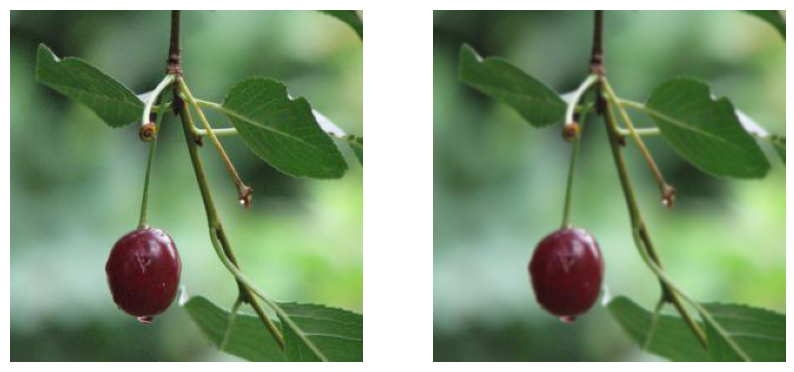

In [15]:
display_images(cherry_images[0], blurred_cherry_images[0], "Cherry")

# Step 3: Build a simple Baseline model

You should build a simple/standard neural network, i.e. multiplayer perceptron (MLP) trained by back-propagation for this step, which helps you have a baseline intuition / idea of the task. It is probably easiest to just do this in PyTorch. Don't use a CNN for this part! The point is to get a sense of how well a "vanilla" neural net can do, without convolutions. Because it is "dense", this probably can't be too large, as it has to be trained in a reasonable amount of time. Start small and see how you go.

In [16]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if len(image.shape) == 2:
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        return image, torch.tensor(label, dtype=torch.long)

In [17]:
blurred_cherry_images = preprocess_images(blurred_cherry_images)
blurred_strawberry_images = preprocess_images(blurred_strawberry_images)
blurred_tomato_images = preprocess_images(blurred_tomato_images)

print("PROCESSED IMAGES")

blurred_cherry_labels = np.zeros(blurred_cherry_images.shape[0])
blurred_strawberry_labels = np.ones(blurred_strawberry_images.shape[0])
blurred_tomato_labels = np.full(blurred_tomato_images.shape[0], 2)

print("PERFORMED LABEL ENCODING")

blurred_features = np.concatenate([blurred_cherry_images, blurred_strawberry_images, blurred_tomato_images])
blurred_labels = np.concatenate([blurred_cherry_labels, blurred_strawberry_labels, blurred_tomato_labels])

print("FEATURES SHAPE:", blurred_features.shape)
print("LABELS SHAPE:", blurred_labels.shape)

x_blurred_train, x_blurred_test, y_blurred_train, y_blurred_test = train_test_split(
    blurred_features, blurred_labels, test_size=0.3, random_state=42
)

print("SHAPES OF TRAIN AND TEST SPLIT")
print("XT", x_blurred_train.shape)
print("XTST", x_blurred_test.shape)
print("YT", y_blurred_train.shape)
print("YTST", y_blurred_test.shape)

PROCESSED IMAGES
PERFORMED LABEL ENCODING
FEATURES SHAPE: (4380, 300, 300, 3)
LABELS SHAPE: (4380,)
SHAPES OF TRAIN AND TEST SPLIT
XT (3066, 300, 300, 3)
XTST (1314, 300, 300, 3)
YT (3066,)
YTST (1314,)


In [18]:
class BlurredModel(nn.Module):
    def __init__(self):
        super(BlurredModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(300 * 300 * 3, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

blurred_model_torch = BlurredModel()
blurred_criterion = nn.CrossEntropyLoss()
blurred_optimizer = optim.Adam(blurred_model_torch.parameters(), lr=0.001)

In [19]:
blurred_train_dataset = ImageDataset(x_blurred_train, y_blurred_train)
blurred_test_dataset = ImageDataset(x_blurred_test, y_blurred_test)

blurred_train_loader = DataLoader(blurred_train_dataset, batch_size=32, shuffle=True)
blurred_test_loader = DataLoader(blurred_test_dataset, batch_size=32, shuffle=False)

In [20]:
blurred_num_epochs = 20

blurred_train_losses = []
blurred_test_losses = []
blurred_train_accuracies = []
blurred_test_accuracies = []

for epoch in range(blurred_num_epochs):
    blurred_model_torch.train()
    blurred_running_loss = 0.0
    blurred_correct = 0
    blurred_total = 0

    for images, labels in blurred_train_loader:
        blurred_optimizer.zero_grad()
        blurred_outputs = blurred_model_torch(images)
        blurred_loss = blurred_criterion(blurred_outputs, labels)
        blurred_loss.backward()
        blurred_optimizer.step()

        blurred_running_loss += blurred_loss.item()

    blurred_train_loss = blurred_running_loss / len(blurred_train_loader)
    blurred_train_losses.append(blurred_train_loss)

    _, blurred_predicted = torch.max(blurred_outputs.data, 1)
    blurred_total += labels.size(0)
    blurred_correct += (blurred_predicted == labels).sum().item()
    blurred_train_accuracy = blurred_correct / blurred_total
    blurred_train_accuracies.append(blurred_train_accuracy)

    print(f'Epoch [{epoch + 1}/{blurred_num_epochs}], Loss: {blurred_train_loss:.4f}, Accuracy: {blurred_train_accuracy:.2f}')

Epoch [1/20], Loss: 19.6281, Accuracy: 0.42
Epoch [2/20], Loss: 4.1637, Accuracy: 0.54
Epoch [3/20], Loss: 2.7153, Accuracy: 0.46
Epoch [4/20], Loss: 2.7122, Accuracy: 0.62
Epoch [5/20], Loss: 1.7119, Accuracy: 0.27
Epoch [6/20], Loss: 1.0770, Accuracy: 0.38
Epoch [7/20], Loss: 1.3081, Accuracy: 0.38
Epoch [8/20], Loss: 0.9435, Accuracy: 0.62
Epoch [9/20], Loss: 0.9148, Accuracy: 0.42
Epoch [10/20], Loss: 0.8949, Accuracy: 0.58
Epoch [11/20], Loss: 0.7883, Accuracy: 0.69
Epoch [12/20], Loss: 0.8509, Accuracy: 0.65
Epoch [13/20], Loss: 0.8179, Accuracy: 0.77
Epoch [14/20], Loss: 0.9025, Accuracy: 0.62
Epoch [15/20], Loss: 0.7781, Accuracy: 0.73
Epoch [16/20], Loss: 0.9175, Accuracy: 0.58
Epoch [17/20], Loss: 0.7629, Accuracy: 0.69
Epoch [18/20], Loss: 0.7445, Accuracy: 0.77
Epoch [19/20], Loss: 0.7709, Accuracy: 0.73
Epoch [20/20], Loss: 0.7308, Accuracy: 0.54


In [21]:
blurred_model_torch.eval()
with torch.no_grad():
    blurred_running_test_loss = 0.0
    blurred_correct = 0
    blurred_total = 0
    for images, labels in blurred_test_loader:
        blurred_outputs = blurred_model_torch(images)
        blurred_loss = blurred_criterion(blurred_outputs, labels)
        blurred_running_test_loss += blurred_loss.item()
        
        _, blurred_predicted = torch.max(blurred_outputs.data, 1)
        blurred_total += labels.size(0)
        blurred_correct += (blurred_predicted == labels).sum().item()

    blurred_test_loss = blurred_running_test_loss / len(blurred_test_loader)
    blurred_test_accuracy = 100 * blurred_correct / blurred_total
    blurred_test_losses.append(blurred_test_loss)
    blurred_test_accuracies.append(blurred_test_accuracy)

    print(f'Test Loss: {blurred_test_loss:.4f}, Test Accuracy: {blurred_test_accuracy:.2f}%')

Test Loss: 1.2463, Test Accuracy: 45.05%


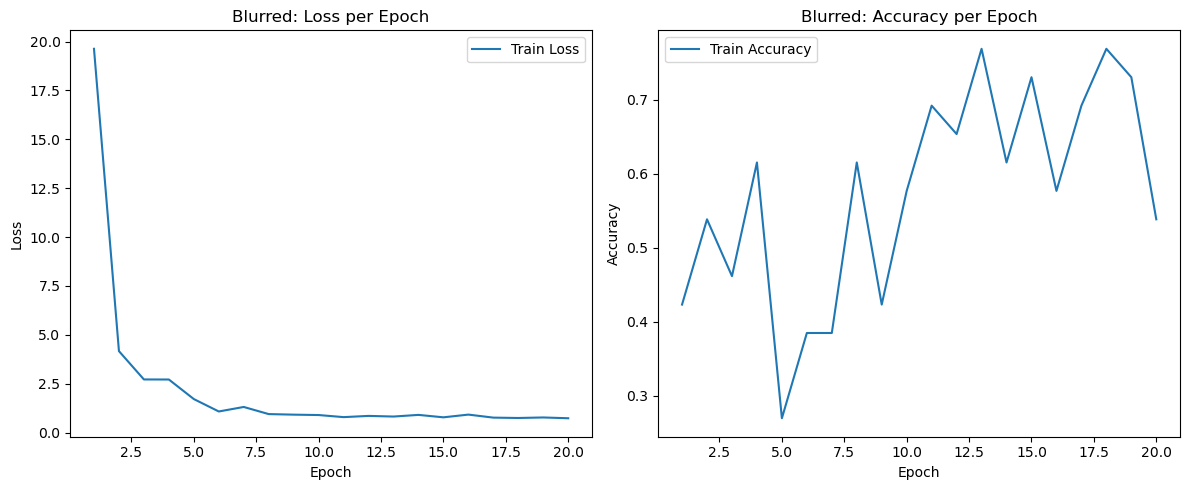

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, blurred_num_epochs + 1), blurred_train_losses, label='Train Loss')
plt.title('Blurred: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, blurred_num_epochs + 1), blurred_train_accuracies, label='Train Accuracy')
plt.title('Blurred: Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()